In [7]:
#mengimpor library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import os
# Set the environment variable
os.environ['OMP_NUM_THREADS' ] = '1'

In [8]:
path = "..\Dataset\API_Kaggle\Mall_Customers.csv"
df = pd.read_csv(path)
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [9]:
#Data Preprocessing
new_names = {
    'Annual Income (k$)': 'AnnualIncome',
    'Spending Score (1-100)': 'SpendingScore'
}
df.rename(columns=new_names, inplace=True)
#hapus kolom CustomerID karena bukan fitur untuk clustering
if 'CustomerID' in df.columns:
    df = df.drop(columns=['CustomerID'])
df

,Gender,Age,AnnualIncome,SpendingScore
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [10]:
df.isna().sum()

Gender           0
Age              0
AnnualIncome     0
SpendingScore    0
dtype: int64

In [11]:
#melakukan imputasi dengan nilai Mean untuk kolom numerik: Age, AnnualIncome, SpendingScore
num_cols = [c for c in ['Age', 'AnnualIncome', 'SpendingScore'] if c in df.columns]
for c in num_cols:
    df[c] = df[c].fillna(value=df[c].mean())
df.isna().sum()

Gender           0
Age              0
AnnualIncome     0
SpendingScore    0
dtype: int64

In [12]:
#melakukan imputasi dengan nilai Modus untuk kolom Gender (jika ada)
if 'Gender' in df.columns:
    modus = df['Gender'].mode()[0]
    df['Gender'] = df['Gender'].fillna(modus)
df.isna().sum()

Gender           0
Age              0
AnnualIncome     0
SpendingScore    0
dtype: int64

In [13]:
le = LabelEncoder()
#encode Gender jika ada
feature = ['Gender']
if 'Gender' in df.columns:
    df[feature] = df[feature].apply(le.fit_transform)
df

,Gender,Age,AnnualIncome,SpendingScore
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


In [14]:
scaler = MinMaxScaler()
#Pilih kolom yang akan dipakai sebagai fitur untuk clustering
#Gunakan Gender(ter-encode), Age, AnnualIncome, SpendingScore bila tersedia
feature_cols = [c for c in ['Gender', 'Age', 'AnnualIncome', 'SpendingScore'] if c in df.columns]
X = scaler.fit_transform(df[feature_cols])
X

array([[1.        , 0.01923077, 0.        , 0.3877551 ],
       [1.        , 0.05769231, 0.        , 0.81632653],
       [0.        , 0.03846154, 0.00819672, 0.05102041],
       [0.        , 0.09615385, 0.00819672, 0.7755102 ],
       [0.        , 0.25      , 0.01639344, 0.39795918],
       [0.        , 0.07692308, 0.01639344, 0.76530612],
       [0.        , 0.32692308, 0.02459016, 0.05102041],
       [0.        , 0.09615385, 0.02459016, 0.94897959],
       [1.        , 0.88461538, 0.03278689, 0.02040816],
       [0.        , 0.23076923, 0.03278689, 0.7244898 ],
       [1.        , 0.94230769, 0.03278689, 0.13265306],
       [0.        , 0.32692308, 0.03278689, 1.        ],
       [0.        , 0.76923077, 0.04098361, 0.14285714],
       [0.        , 0.11538462, 0.04098361, 0.7755102 ],
       [1.        , 0.36538462, 0.04098361, 0.12244898],
       [1.        , 0.07692308, 0.04098361, 0.79591837],
       [0.        , 0.32692308, 0.04918033, 0.34693878],
       [1.        , 0.03846154,

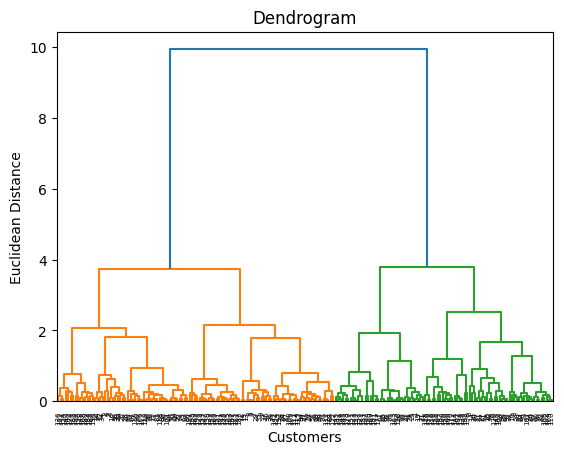

In [15]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

In [16]:
#Data Clustering and Evaluation
#Membangun model klustering dengan beberapa pilihan nomor kluster
#Menguji dengan metrik Davies Bouldin Score,
#Silhouette Score dan Calinski-Harabasz Index
# gunakan dictionary untuk menyimpan metrik per jumlah kluster
db, slc, chs = {}, {}, {}
for i in range(2, 10):
    hc = AgglomerativeClustering(n_clusters=i, metric='euclidean', memory=None,
    connectivity=None, compute_full_tree='auto',
    linkage='ward', distance_threshold=None, compute_distances=False)
    y_hc = hc.fit_predict(X)

    db[i] = davies_bouldin_score(X, y_hc)
    slc[i] = silhouette_score(X, y_hc)
    chs[i] = calinski_harabasz_score(X, y_hc)
    print("Kluster {}".format(i))
    print("Davies Bouldin Score = {}".format(db[i]))
    print("Silhouette Score = {}".format(slc[i]))
    print("Calinski-Harabasz Index = {}".format(chs[i]))

Kluster 2
Davies Bouldin Score = 0.8172534497318453
Silhouette Score = 0.5194624832665107
Calinski-Harabasz Index = 262.4745661327262
Kluster 3
Davies Bouldin Score = 1.002191080960564
Silhouette Score = 0.446997943122699
Calinski-Harabasz Index = 185.71796856516679
Kluster 4
Davies Bouldin Score = 1.1723991961576188
Silhouette Score = 0.3444266582171814
Calinski-Harabasz Index = 179.6445568175751
Kluster 5
Davies Bouldin Score = 1.0941951795238576
Silhouette Score = 0.35032447507156306
Calinski-Harabasz Index = 163.46602356383625
Kluster 6
Davies Bouldin Score = 1.0475990677075202
Silhouette Score = 0.3460050179221861
Calinski-Harabasz Index = 152.17123414035214
Kluster 7
Davies Bouldin Score = 1.0182092441867832
Silhouette Score = 0.3643550186201911
Calinski-Harabasz Index = 148.2057465064058
Kluster 8
Davies Bouldin Score = 0.9899326975808629
Silhouette Score = 0.3659419625588666
Calinski-Harabasz Index = 147.48763374871362
Kluster 9
Davies Bouldin Score = 0.9204312705070462
Silhoue

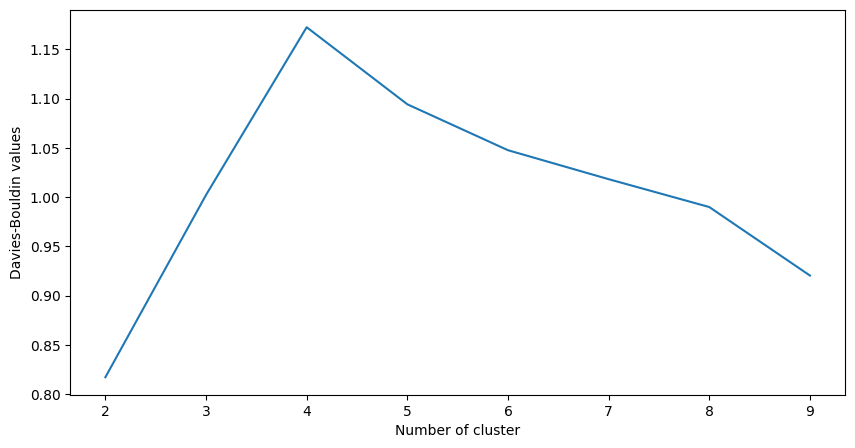

In [17]:
#Menampilkan visualisasi nilai Davies-Bouldin Score
plt.figure(figsize=(10,5))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

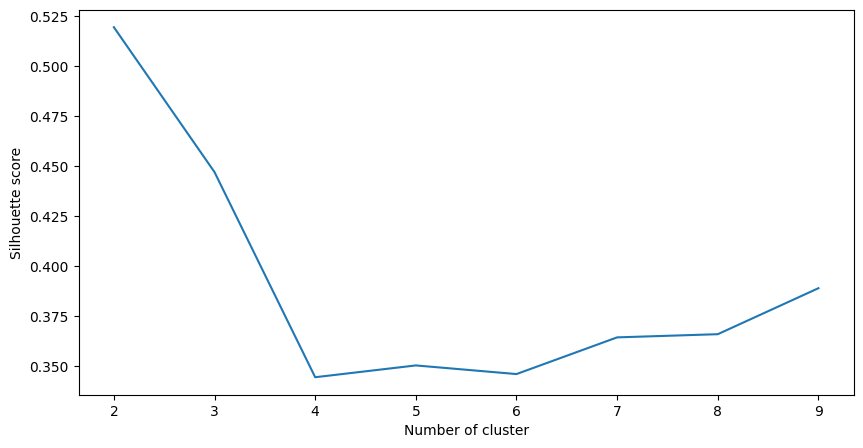

In [18]:
#Menampilkan visualisasi nilai Silhouette score
plt.figure(figsize=(10,5))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

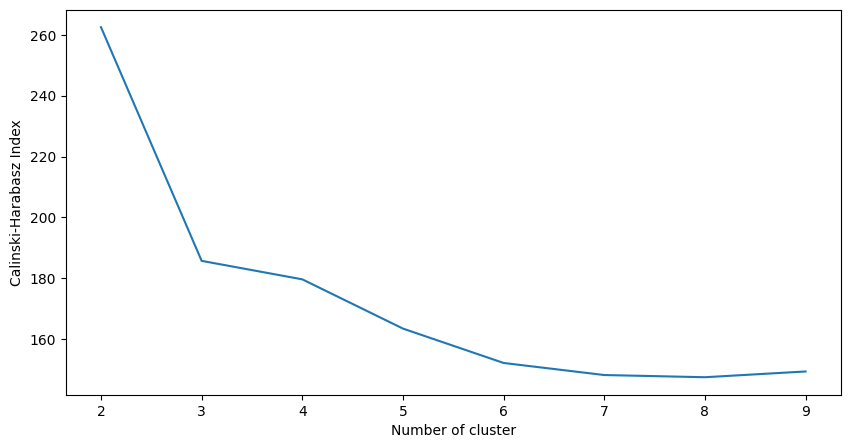

In [19]:
#Menampilkan visualisasi nilai Calinski-Harabasz Index
plt.figure(figsize=(10,5))
plt.plot(list(chs.keys()), list(chs.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Calinski-Harabasz Index")
plt.show()

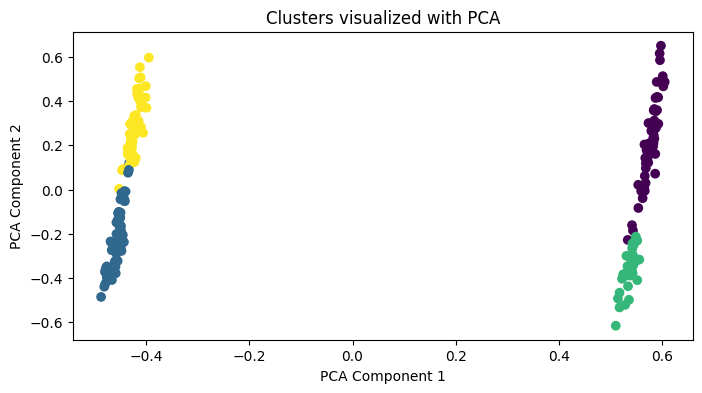

In [20]:
#Menampilkan hasil visualisasi clustering dengan nilai kluster=4
#menggunakan metode PCA untuk reduksi dimensi menjadi 2 dimensi
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', memory=None,
connectivity=None, compute_full_tree='auto',
linkage='ward', distance_threshold=None, compute_distances=False)

y_hc = hc.fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_hc, cmap='viridis')
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

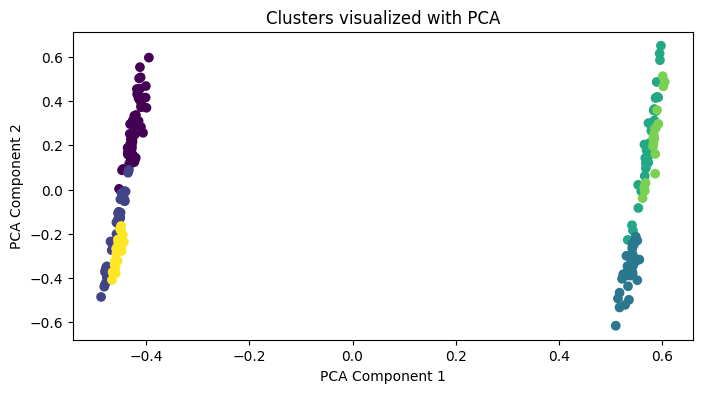

In [21]:
#Menampilkan hasil visualisasi clustering dengan nilai kluster=6
#menggunakan metode PCA untuk reduksi dimensi menjadi 2 dimensi
hc = AgglomerativeClustering(n_clusters=6, metric='euclidean', memory=None,
connectivity=None, compute_full_tree='auto',
linkage='ward', distance_threshold=None, compute_distances=False)

y_hc = hc.fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_hc, cmap='viridis')
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

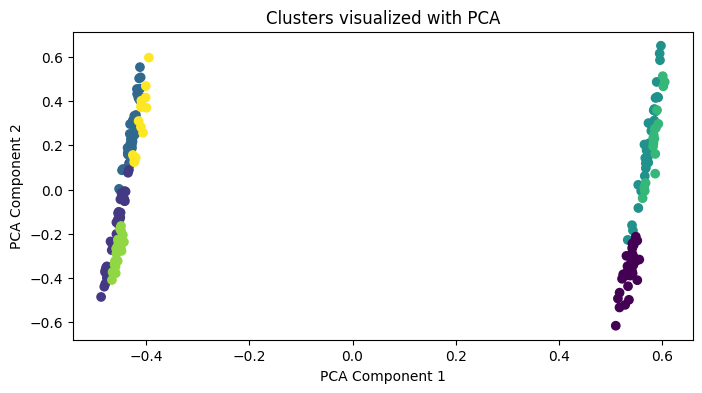

In [22]:
#Menampilkan hasil visualisasi clustering dengan nilai kluster=7
#menggunakan metode PCA untuk reduksi dimensi menjadi 2 dimensi
hc = AgglomerativeClustering(n_clusters=7, metric='euclidean', memory=None,
connectivity=None, compute_full_tree='auto',
linkage='ward', distance_threshold=None, compute_distances=False)

y_hc = hc.fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_hc, cmap='viridis' )
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()